In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import re
import pandas as pd
from transformers import AutoTokenizer
from datasets import Dataset, load_from_disk

### Load Model and Tokenizer

In [3]:

MODEL_CKPT = 'EleutherAI/polyglot-ko-5.8b'
MODEL_CKPT = 'EleutherAI/polyglot-ko-3.8b'
MODEL_CKPT = 'EleutherAI/polyglot-ko-1.3b'
MODEL_CKPT = 'paust/pko-t5-base'
MODEL_CKPT = 'paust/pko-t5-large'

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

print(MODEL_CKPT)

paust/pko-t5-large


### Load Data

In [4]:
DATA_PATH = 'data/model_dev_raw/model_dev_raw_v4.pickle'

In [5]:
df_data = pd.read_pickle(DATA_PATH)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100146 entries, 0 to 100885
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             100146 non-null  int64         
 1   create_date    100146 non-null  datetime64[ns]
 2   title          100146 non-null  object        
 3   title_content  100146 non-null  object        
 4   len_tokenized  100146 non-null  int64         
 5   label          100146 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 5.3+ MB


In [6]:
# for idx, row in df_data.iterrows():
#     if idx == 1000:
#         break
#     print(f'Row {idx}')
#     print('input')
#     print(row.title_content)
#     print()
#     print('output')
#     print(row.label)
#     print()
#     print()

### 전처리 계획

- 라벨 앞뒤로 붙은 punctuation 제거
- 라벨 내 key-phrases 중에서 띄어쓰기 기준으로 길이 4 이상인 항목 제거 (보류)

### Preprocess

In [7]:
def regulate_sequence(string):
    pattern = re.compile(r'- .+\n') # - 댄스가수 유랑단 > 댄스가스 유랑단; 
    found = pattern.findall(string)
    if len(found) > 5:
        removed = [re.sub(r'^- ', '', keyphrase) for keyphrase in found]
        string = '; '.join(removed)

    pattern = re.compile(r'\d+\. .+\n') # 1. 댄스가수 유랑단 > 댄스가스 유랑단; 
    found = pattern.findall(string)
    if len(found) > 5:
        removed = [re.sub(r'^\d+\. ', '', keyphrase) for keyphrase in found]
        string = '; '.join(removed)
    
    return string

In [8]:
def remove_noises(string):
    string = re.sub(r'key-phrases:', '', string, flags=re.IGNORECASE)
    string = string.replace('\n', ' ').strip()
    
    if string[0] in ';.':
        string = string[1:]
    if string[-1] in ';.':
        string = string[:-1]
    return string.strip()

test_case = '; 농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융; '
test_case = ';농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융. '

remove_noises(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [9]:
def remove_quotes(string):
    quotes = '"' + "'"
    key_phrases = [key_phrase.strip() for key_phrase in string.split(';') if key_phrase != '']

    temp = []
    for key_phrase in key_phrases:
        if len(key_phrase) > 0 and key_phrase[0] in quotes and key_phrase[-1] in quotes:
            key_phrase = key_phrase[1:-1]
        temp.append(key_phrase)
    
    return '; '.join(temp)

test_case = "'농협은행'; 'ESG경영'; '상생경영'; '제1회 대한민국 리딩금융 ESG 어워드'; '친환경경영'; '지배구조'; '녹색금융'"

remove_quotes(test_case)

'농협은행; ESG경영; 상생경영; 제1회 대한민국 리딩금융 ESG 어워드; 친환경경영; 지배구조; 녹색금융'

In [10]:
def preprocess_str(string):
    string = regulate_sequence(string)
    string = remove_noises(string)
    string = remove_quotes(string)
    return string

In [11]:
def preprocess(df):
    df.rename(columns={'title_content': 'input_text', 'label': 'target_text'}, inplace=True)
    df['target_text'] = df['target_text'].apply(preprocess_str)
    return df

In [12]:
preprocessed_data = preprocess(df_data)

### Check Preprocessed

In [13]:
checker = preprocessed_data.target_text.str.contains('\n')
checker = preprocessed_data.target_text.str.contains(r'^- ', regex=True)
checker = preprocessed_data.target_text.str.contains(r'^\d+\. ', regex=True)
checker = preprocessed_data.target_text.str.contains('key-phrases:')
checked = preprocessed_data[checker]

for idx, row in checked.iterrows():
    print(f'Row {idx}')
    print('target_text')
    print(row.target_text)
    print()

### Add len_tokenized_target_text Col. and Investigate

In [14]:
preprocessed_data['len_tokenized_target_text'] = preprocessed_data.target_text.apply(lambda x: len(tokenizer(x)['input_ids']))

(<Axes: >,
 count    100146.000000
 mean         55.936613
 std          21.578053
 min           2.000000
 25%          44.000000
 50%          51.000000
 75%          62.000000
 max         826.000000
 Name: len_tokenized_target_text, dtype: float64)

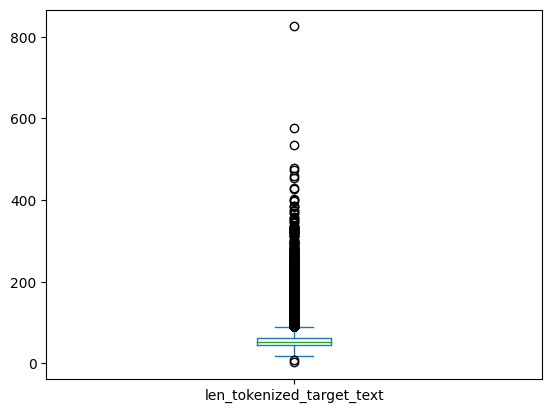

In [15]:
preprocessed_data.len_tokenized_target_text.plot(kind='box'), preprocessed_data.len_tokenized_target_text.describe()

### seq len =< 64 labels only

In [16]:
checker = preprocessed_data.len_tokenized_target_text <= 64
preprocessed_data[checker].len_tokenized_target_text.describe()
preprocessed_data = preprocessed_data[checker]
preprocessed_data.len_tokenized_target_text.describe()

count    79472.000000
mean        48.362316
std          8.084109
min          2.000000
25%         42.000000
50%         48.000000
75%         55.000000
max         64.000000
Name: len_tokenized_target_text, dtype: float64

In [17]:
# cursor = 0
# for idx, row in preprocessed_data.iterrows():
#     keyphrases = row.target_text.split('; ')
#     for keyphrase in keyphrases:
#         if keyphrase not in row.input_text:
#             print(row.input_text)
#             print(keyphrase)
#             print()
#             cursor += 1
#             if cursor == 100:
#                 break
#     if cursor == 100:
#         break

In [18]:
# for idx, row in preprocessed_data.iterrows():
#     print(f'Row {idx}')
#     print('target_text')
#     print(row.target_text)
#     print()

### Save Preprocessed Data

In [19]:
# preprocessed_data.to_pickle('data/model_dev/model_dev_v4.pickle')

### Encoding / Train Eval Split

In [20]:
### seq2seq
prefix = "generate keyphrases: "
max_input_length = 1024
max_target_length = 64

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["input_text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding=False)

    labels = tokenizer(examples["target_text"], max_length=max_target_length, truncation=True, padding=False)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [21]:
# ### clm
# MODEL_CKPT = 'EleutherAI/polyglot-ko-1.3b'
# tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# max_length = 2048
# src_prefix = '[generate keyphrases]'
# trg_prefix = '[keyphrases generated]'
# custom_eos = '[end of generation]'

# def preprocess_function(examples):
#     inputs = [src_prefix + src + trg_prefix + trg + custom_eos for src, trg in zip(examples["input_text"], examples["target_text"])]
#     model_inputs = tokenizer(inputs, max_length=max_length, truncation=True, padding=False)
#     return model_inputs

# new_tokens = ['[generate keyphrases]', '[keyphrases generated]', '[end of generation]']
# tokenizer.add_tokens(new_tokens)
# tokenizer.save_pretrained('clm_tokenizer')

In [22]:
# ### for testing training script
# preprocessed_data = preprocessed_data[:1000]
# dataset = Dataset.from_pandas(preprocessed_data).shuffle(seed=100).train_test_split(0.2, seed=100)

dataset = Dataset.from_pandas(preprocessed_data).shuffle(seed=100).train_test_split(3000, seed=100)
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [23]:
train_dataset = train_dataset.map(
    preprocess_function, 
    batched=True, 
    num_proc=4, 
    remove_columns=train_dataset.column_names
)

eval_dataset = eval_dataset.map(
    preprocess_function, 
    batched=True, 
    num_proc=4,
)

print(train_dataset)
print(eval_dataset)

Map (num_proc=4):   0%|          | 0/76472 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 76472
})
Dataset({
    features: ['id', 'create_date', 'title', 'input_text', 'len_tokenized', 'target_text', 'len_tokenized_target_text', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3000
})


In [24]:
train_dataset.save_to_disk('data/model_dev/model_dev_v4_paust_t5_large_train.hf')
eval_dataset.save_to_disk('data/model_dev/model_dev_v4_paust_t5_large_eval.hf')

Saving the dataset (0/1 shards):   0%|          | 0/76472 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

In [25]:
train_dataset = load_from_disk('data/model_dev/model_dev_v4_paust_t5_large_train.hf')
eval_dataset = load_from_disk('data/model_dev/model_dev_v4_paust_t5_large_eval.hf')

In [26]:
print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 76472
})
Dataset({
    features: ['id', 'create_date', 'title', 'input_text', 'len_tokenized', 'target_text', 'len_tokenized_target_text', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3000
})


In [33]:
import random

rand_idx = random.randint(0, len(eval_dataset)-1)

context = tokenizer.decode(eval_dataset['input_ids'][rand_idx], skip_special_tokens=True)
label = tokenizer.decode(eval_dataset['labels'][rand_idx], skip_special_tokens=True)

print(context)
print()
print(label)

generate keyphrases: 음식점 재룟값 1년새 약 18%↑...양파·스위트콘은 2∼3배로 [마켓보로 제공. 재판매 및 DB금지](서울=연합뉴스) 신선미 기자 = 음식점에서 쓰는 식자재 가격이 1년 새 약 18% 오른 것으로 나타났다.푸드테크 스타트업 마켓보로는 자사 외식 사업자 전용 식자재 구매 앱(애플리케이션) '식봄'에서 판매되는 식자재 2천15개의 지난달 말 가격을 조사한 결과, 1년 전에 비해 평균 17.6% 상승한 것으로 확인됐다고 27일 밝혔다.한국소비자원이 서울 지역의 자장면, 김치찌개, 비빔밥 등 8대 외식 상품 가격을 조사한 결과에서는 같은 기간 10.4% 오른 것으로 나타났는데, 메뉴 가격 상승률보다 식자재 가격 상승률이 더 높았던 셈이다.식봄에서는 식자재 2천15개 중 84.4%인 1천701개의 가격이 오른 것으로 조사됐다.값이 내린 품목은 9.4%(190개)에 불과했고 가격 변동이 없었던 품목은 6.2%(124개)였다.자장면 재료를 살펴보면 밀가루(제면용 20kg)는 1년 새 15.5% 올랐고 식용유(18L)는 22.0%, 춘장(볶음춘장 10kg)은 8.8% 각각 상승했다.양파(15kg)는 182.5%나 오른 것으로 조사됐다.이 밖에 식당에서 많이 쓰는 단무지는 10.2%, 참치캔은 39.5%, 자연산 치즈는 34.8% 오른 것으로 나타났다.멸균우유(1L)는 22.8%, 스위트콘 가격은 121.2% 상승했다.서울 상수동에서 중식당을 운영하는 한 사업자는 재룟값 상승과 관련해 "올해 초 식자재 가격이 많이 올라 메뉴 당 500∼1천원씩 인상을 단행할 수밖에 없었다"고 말했다.망원동에서 주점을 운영하는 백모 씨도 "식자재 가격이 전체적으로 올랐으나 가격이 30% 오른 연어 관련 메뉴만 값을 올렸다"며 "식자재 값 상승에 가스 가격 인상 부담까지, 식당이 고스란히 피해를 떠안고 가야 하는 셈"이라고 토로했다.[마켓보로 제공. 재판매 및 DB금지]sun@yna.co.kr

음식점; 재룟값; 식자재; 가격; 상승; 양파; 스위트콘; 외